![](resources/title.png)

# Tarea en Python usando PySpark para la asignatura de PAB

### El objetivo de la práctica es analizar los datos de indicadores de enfermedades crónicas que se proporcionan en el portal dado, de dónde obtenemos un fichero .csv que contiene los datos a analizar. 

### Usaremos la API de RDDs y la de datasets

### Autores:
* Miguel González 
* Samuel Delgado
* Victoria Cruz

## PyData.py con API RDDs

In [3]:
from pyspark import SparkConf, SparkContext
import sys
import csv
import time

file_name = "resources/U.S._Chronic_Disease_Indicators__CDI_.csv"

sc = SparkContext.getOrCreate()

logger = sc._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)

start_computing_time = time.time()

file = sc \
    .textFile(file_name)
header = file.first()

d = file.filter(lambda line: line != header) \
    .map(lambda line: csv.reader([line], quotechar='"', delimiter=',',
                                 quoting=csv.QUOTE_ALL, skipinitialspace=True).__next__()) \
    .map(lambda r: (r[5], r[6])) \
    .groupByKey() \
    .map(lambda x: (x[0], set(x[1]))) \
    .mapValues(len) \
    .collect()

sum = 0

for pair in d:
    sum += pair[1]
    print(pair)

print("\nTotal sum:", sum)

total_computing_time = time.time() - start_computing_time
print("Computing time: ", str(total_computing_time))


('Asthma', 9)
('Chronic Kidney Disease', 4)
('Older Adults', 4)
('Mental Health', 3)
('Immunization', 1)
('Disability', 1)
('Cancer', 20)
('Oral Health', 9)
('Tobacco', 16)
('Reproductive Health', 3)
('Arthritis', 10)
('Diabetes', 20)
('Cardiovascular Disease', 18)
('Overarching Conditions', 16)
('Alcohol', 16)
('Chronic Obstructive Pulmonary Disease', 16)
('Nutrition, Physical Activity, and Weight Status', 37)

Total sum: 203
Computing time:  7.899585008621216


## PyDataFrame.py con API datasets

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql.functions import col

import sys
import time

file_name = "resources/U.S._Chronic_Disease_Indicators__CDI_.csv"

spark_session = SparkSession \
    .builder \
    .getOrCreate()

logger = spark_session._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)

start_computing_time = time.time()

data_frame = spark_session \
    .read \
    .format("csv") \
    .options(header='true', inferschema='true') \
    .load(file_name)

indicator_freqs = data_frame \
    .groupBy("Topic") \
    .agg(func.countDistinct("Question").alias("freq")) \
    .sort("Topic") \
    
indicator_freqs.show()

frequencies = [x.freq for x in indicator_freqs.select("freq").collect()]

suma = 0
for f in frequencies: 
    suma += f

print("Total sum:",suma)

total_computing_time = time.time() - start_computing_time
print("Computing time: ", str(total_computing_time))

+--------------------+----+
|               Topic|freq|
+--------------------+----+
|             Alcohol|  16|
|           Arthritis|  10|
|              Asthma|   9|
|              Cancer|  20|
|Cardiovascular Di...|  18|
|Chronic Kidney Di...|   4|
|Chronic Obstructi...|  16|
|            Diabetes|  20|
|          Disability|   1|
|        Immunization|   1|
|       Mental Health|   3|
|Nutrition, Physic...|  37|
|        Older Adults|   4|
|         Oral Health|   9|
|Overarching Condi...|  16|
| Reproductive Health|   3|
|             Tobacco|  16|
+--------------------+----+

Total sum: 203
Computing time:  17.136831283569336


## Análisis adicional: frecuencias de enfermedades por estados

In [5]:
start_computing_time = time.time()

data_frame \
    .groupBy("Topic", "LocationDesc") \
    .count() \
    .sort("LocationDesc") \
    .show()

total_computing_time = time.time() - start_computing_time
print("Computing time: ", str(total_computing_time))

+--------------------+------------+-----+
|               Topic|LocationDesc|count|
+--------------------+------------+-----+
|           Arthritis|     Alabama|  768|
|             Tobacco|     Alabama|  539|
|       Mental Health|     Alabama|  133|
|          Disability|     Alabama|   56|
|Cardiovascular Di...|     Alabama| 1399|
|Overarching Condi...|     Alabama|  733|
|         Oral Health|     Alabama|  205|
|              Asthma|     Alabama|  708|
|Nutrition, Physic...|     Alabama|  618|
|Chronic Obstructi...|     Alabama| 1416|
|              Cancer|     Alabama|  262|
|Chronic Kidney Di...|     Alabama|  236|
|             Alcohol|     Alabama|  593|
| Reproductive Health|     Alabama|   38|
|        Immunization|     Alabama|   96|
|        Older Adults|     Alabama|  288|
|            Diabetes|     Alabama| 1442|
|         Oral Health|      Alaska|  205|
|Chronic Kidney Di...|      Alaska|  236|
|Chronic Obstructi...|      Alaska| 1416|
+--------------------+------------

## Gráfico de frecuencias de indicadores de enfermedades con matplotlib

<BarContainer object of 17 artists>

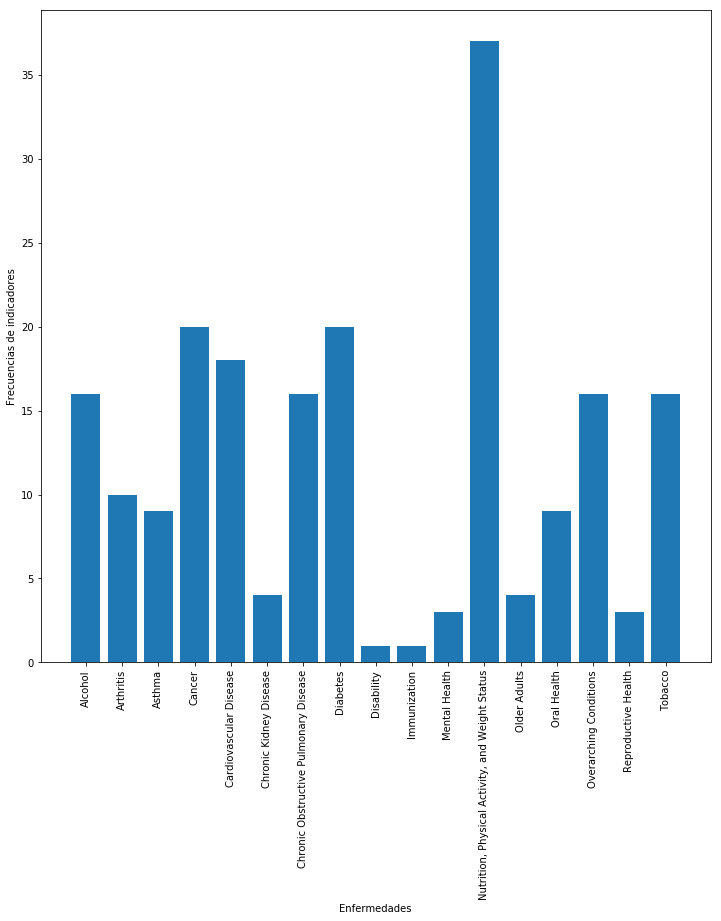

In [9]:
indicator_names = [x.Topic for x in indicator_freqs.select("Topic").collect()]
indicator_count = [x.freq for x in indicator_freqs.select("freq").collect()]
from matplotlib import pyplot
pyplot.figure(figsize=(12, 12))
pyplot.xticks(rotation=90)
pyplot.ylabel("Frecuencias de indicadores")
pyplot.xlabel("Enfermedades")
pyplot.bar(indicator_names, indicator_count ,align='center')